In [1]:
# Note: Original saved in Tahir Sproj folder

# Deep Learning Libraries
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as data

# Data Manipulation and Analysis
import numpy as np
import pandas as pd

# Data Visualization
import matplotlib
import matplotlib.pyplot as plt

# File and System Interaction
import os
from pathlib import Path
import torch.optim as optim


# Date and Time Handling
import time
import datetime

# Linear Algebra
from torch import linalg as LA

# Neural Architecture
try:
    from torchinfo import summary
except:
    # %pip install torchinfo
    from torchinfo import summary

In [23]:
%load_ext autoreload
%autoreload 2

from python_scripts import dataset_processing
from python_scripts import architecture
from python_scripts import revised_architecture
from python_scripts import training
from python_scripts import logs_and_results
from python_scripts import img_pdf_compiler


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Setting up some global variables

ROOT = os.getcwd().replace('\\', '/') + '/HuberMC_Data'
# ROOT = 'C:/Users/Talha/OneDrive - Higher Education Commission/Documents/GitHub/ConvHuberMC/HuberMC_Data'
# ROOT = 'C:/Users/HP/GitHub Workspace/ConvHuberMC-Net/HuberMC_Data'
TRY = 'Try 1'
SESSION = 'Session 3'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device, ROOT

('cpu',
 'c:/Users/Talha/OneDrive - Higher Education Commission/Documents/GitHub/ConvHuberMC/HuberMC_Data')

Testing Training Loop

In [4]:
# Get parameters --> for convhubermc:
def get_default_param(gpu = True, model = 'HuberMC-Net'):
    params_net = {}
    params_net['size1'] = 150
    params_net['size2'] = 300
    params_net['rank'] = 10
    
    params_net['device'] = device

    if model == 'HuberMC-Net':
        params_net['hubreg_iters'] = 2
    elif model == 'LP1':
        params_net['inner_iters'] = 2
        
    params_net['layers'] = 3
    params_net['kernel'] = (3, 3)
    
    params_net['CalInGPU'] = gpu
    
    return params_net

In [5]:
class Conv2dC(nn.Module):
    def __init__(self, kernel): # Empirically found to be self.kernel to maintain same shape
        super(Conv2dC, self).__init__()

        # Given a kernel size of 2 dimensions, we calculate the padding through the formula (k[0] - 1)/2 --> this helps maintain the shape as close as possible
        pad0 = int((kernel[0] - 1) / 2)
        pad1 = int((kernel[1] - 1) / 2)
        if torch.cuda.is_available():
            self.convR = nn.Conv2d(1, 1, (kernel[0], kernel[0]), (1, 1), (pad0, pad1), groups = 1).cuda()
        else:
            self.convR = nn.Conv2d(1, 1, (kernel[0], kernel[0]), (1, 1), (pad0, pad1), groups = 1).to('cpu')
        
        # Initialize weights to zero
        self.convR.weight.data.zero_()

        # For a 3x3 kernel, set the center value to 1 to approximate an identity operation
        if kernel[0] == 3 and kernel[1] == 3:
            self.convR.weight.data[0, 0, 1, 1] = 1

        # Set bias to zero
        self.convR.bias.data.zero_()
        # At groups = in_channels, each input channel is convolved with its own set of filters (of size out_channels/in_channels)

    def forward(self, x):
        # get the height dimension and convert it to int
        n = x.shape[-1]
        # This line creates a new tensor xR by slicing the input tensor along the columns dimension (0:n). The None adds an extra dimension, making xR a 4-dimensional tensor with size (1, 1, H, W).
        # The 1's make sure the consistency with the conv operation which is expecting a in_channels, out_channels, which are set to 1
        xR = x[None, None, :, 0:n].clone()
        xR = self.convR(xR)
        # Removing the extra dimension
        xR = xR.squeeze()
        x = xR
        return x

In [6]:
conv_op = Conv2dC(kernel = (3, 3))

In [7]:
test = torch.randn(150, 10)
test2 = test * 0.01

test[:10, :10], test2[:10, :10]

(tensor([[ 6.8881e-01,  1.1912e-01,  3.6523e+00,  1.0410e-01, -2.3979e-01,
          -1.5193e-01, -5.8620e-01,  7.5602e-01, -1.1917e+00, -5.3552e-01],
         [ 3.8613e-01, -3.3701e-01, -2.4367e+00,  8.0928e-01,  2.0553e+00,
          -7.5597e-01, -9.8536e-01, -3.1243e-01, -2.0315e+00, -1.0597e+00],
         [ 1.4733e-01, -5.2234e-01,  4.1729e-01,  8.2231e-01, -1.6066e-01,
           8.6506e-02,  7.8791e-01, -3.0938e-01,  1.8582e+00,  1.8808e+00],
         [-9.4668e-01,  2.7926e-03,  1.0760e+00, -1.8669e+00, -5.7272e-01,
           2.0427e+00,  6.1051e-03,  6.9947e-01,  4.8721e-01,  1.0490e+00],
         [ 4.6475e-01,  1.9995e+00,  7.7303e-03, -7.7050e-01,  2.2461e-01,
          -4.0902e-01,  4.0365e-01, -3.2824e-01, -2.1672e-01, -5.8281e-01],
         [-1.1063e-01,  5.0243e-01, -9.1922e-02, -2.8413e-01,  2.0263e+00,
           9.9791e-01,  5.1758e-01, -1.7228e+00, -1.5064e+00, -1.5869e+00],
         [-3.3347e-01,  3.2403e-01,  4.9551e-01,  1.1229e-02, -1.1195e+00,
           1.1633e+

In [8]:
test3, test4 = conv_op(test), conv_op(test2)

test3[:10, :10], test4[:10, :10]

(tensor([[ 6.8881e-01,  1.1912e-01,  3.6523e+00,  1.0410e-01, -2.3979e-01,
          -1.5193e-01, -5.8620e-01,  7.5602e-01, -1.1917e+00, -5.3552e-01],
         [ 3.8613e-01, -3.3701e-01, -2.4367e+00,  8.0928e-01,  2.0553e+00,
          -7.5597e-01, -9.8536e-01, -3.1243e-01, -2.0315e+00, -1.0597e+00],
         [ 1.4733e-01, -5.2234e-01,  4.1729e-01,  8.2231e-01, -1.6066e-01,
           8.6506e-02,  7.8791e-01, -3.0938e-01,  1.8582e+00,  1.8808e+00],
         [-9.4668e-01,  2.7926e-03,  1.0760e+00, -1.8669e+00, -5.7272e-01,
           2.0427e+00,  6.1051e-03,  6.9947e-01,  4.8721e-01,  1.0490e+00],
         [ 4.6475e-01,  1.9995e+00,  7.7303e-03, -7.7050e-01,  2.2461e-01,
          -4.0902e-01,  4.0365e-01, -3.2824e-01, -2.1672e-01, -5.8281e-01],
         [-1.1063e-01,  5.0243e-01, -9.1922e-02, -2.8413e-01,  2.0263e+00,
           9.9791e-01,  5.1758e-01, -1.7228e+00, -1.5064e+00, -1.5869e+00],
         [-3.3347e-01,  3.2403e-01,  4.9551e-01,  1.1229e-02, -1.1195e+00,
           1.1633e+

In [9]:
# seed = 123
# torch.manual_seed(seed)
# target = (torch.randn(30, 50))
# input_tensor = target * torch.bernoulli(torch.full((30, 50), 0.2))
# model = architecture.UnfoldedNet_Huber(params = get_default_param(False))

# criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters())

# model.train()
# output = model(input_tensor)

# loss = (criterion(output, target))/torch.square(torch.norm(target, p = 'fro'))
# optimizer.zero_grad()
# print(f'loss before backward: {loss}, loss.grad: {loss.requires_grad}')
# loss.backward()
# print(f'loss: {loss}')
# print("\nGradients after one epoch:")
# for name, param in model.named_parameters():
#     print(f'name: {name}\t\tgradient: {param.grad}')
# optimizer.step()

In [10]:
# # Create a input_tensor of random indices
# shuffled_indices = torch.randperm(input_tensor.nelement())

# # Index the original input_tensor with these shuffled indices
# shuffled_input_tensor = input_tensor.view(-1)[shuffled_indices].view(input_tensor.size())

# output = model(shuffled_input_tensor)

# loss = (criterion(output, target))/torch.square(torch.norm(target, p = 'fro'))
# optimizer.zero_grad()
# print(f'loss before backward: {loss}, loss.grad: {loss.requires_grad}')
# loss.backward()
# print(f'loss: {loss}')
# print("\nGradients after one epoch:")
# for name, param in model.named_parameters():
#     print(f'name: {name}\t\tgradient: {param.grad}')
# optimizer.step()

In [11]:
# # Create a input_tensor of random indices
# shuffled_indices = torch.randperm(input_tensor.nelement())

# # Index the original input_tensor with these shuffled indices
# shuffled_input_tensor = input_tensor.view(-1)[shuffled_indices].view(input_tensor.size())

# output = model(shuffled_input_tensor)

# loss = (criterion(output, target))/torch.square(torch.norm(target, p = 'fro'))
# optimizer.zero_grad()
# print(f'loss before backward: {loss}, loss.grad: {loss.requires_grad}')
# loss.backward()
# print(f'loss: {loss}')
# print("\nGradients after one epoch:")
# for name, param in model.named_parameters():
#     print(f'name: {name}\t\tgradient: {param.grad}')
# optimizer.step()

In [5]:
model = revised_architecture.UnfoldedNet_Huber(params = get_default_param(False, model = 'HuberMC-Net'))
model

UnfoldedNet_Huber(
  (conv_layers): ModuleList(
    (0-449): 450 x Conv2dC(
      (convR): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (huber_obj): Sequential(
    (0): Huber(
      (conv_layers): ModuleList(
        (0-449): 450 x Conv2dC(
          (convR): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
      )
    )
    (1): Huber(
      (conv_layers): ModuleList(
        (0-449): 450 x Conv2dC(
          (convR): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
      )
    )
    (2): Huber(
      (conv_layers): ModuleList(
        (0-449): 450 x Conv2dC(
          (convR): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
      )
    )
  )
)

In [6]:
model.forward(torch.randn(150, 300) * torch.bernoulli(torch.full((150, 300), 0.2)))
# model.forward(torch.randn(30, 50) * torch.bernoulli(torch.full((30, 50), 0.2)))

tensor([[ 0.5256,  1.0422, -1.9632,  ...,  1.3422,  0.1129, -2.2418],
        [ 0.9523, -1.0603, -0.2720,  ..., -1.0151, -0.1060,  0.1597],
        [ 0.7565,  1.0096, -0.2160,  ...,  2.4402, -0.0155, -0.6246],
        ...,
        [ 0.4692, -0.7466, -0.6172,  ..., -1.7032,  0.0357,  0.3596],
        [-0.0434,  0.0179, -0.6514,  ..., -0.2514, -0.1809, -0.7110],
        [-0.9496, -0.8248,  0.5483,  ..., -2.1324,  0.0436,  0.6367]],
       grad_fn=<MmBackward0>)

In [7]:
summary(model, input_size = [150, 300])

Layer (type:depth-idx)                   Output Shape              Param #
UnfoldedNet_Huber                        [150, 300]                --
├─Sequential: 1-1                        [150, 300]                --
│    └─Huber: 2-1                        [150, 300]                4,500
│    └─Huber: 2-4                        --                        (recursive)
│    │    └─ModuleList: 3-3              --                        (recursive)
│    └─Huber: 2-3                        [150, 300]                4,500
│    └─Huber: 2-4                        --                        (recursive)
│    │    └─ModuleList: 3-3              --                        (recursive)
│    └─Huber: 2-5                        [150, 300]                4,500
│    │    └─ModuleList: 3-3              --                        (recursive)
Total params: 17,990
Trainable params: 17,990
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 27
Input size (MB): 0.18
Forward/backward pass size (MB): 21.60
Pa

Project Name: Try 1 HuberMC-Net Q 20.0% DB 9.0

Configuring Network...
Instantiating Model...
Model Instantiated...

Parameters = 
{'size1': 150, 'size2': 300, 'rank': 10, 'device': 'cpu', 'hubreg_iters': 2, 'layers': 3, 'kernel': (3, 3), 'CalInGPU': False}

Epoch: 1, 2024-05-22 17:20:29, 

Epoch [1/20], Mean Training Loss:6.25944e-05, Mean Validation Loss:2.48947e-05
Epoch: 2, 2024-05-22 17:24:10, 

Epoch [2/20], Mean Training Loss:6.03170e-05, Mean Validation Loss:2.48563e-05
Epoch: 3, 2024-05-22 17:27:45, 

Epoch [3/20], Mean Training Loss:5.89489e-05, Mean Validation Loss:2.49239e-05
Epoch: 4, 2024-05-22 17:31:20, 

Epoch [4/20], Mean Training Loss:5.80522e-05, Mean Validation Loss:2.49008e-05
Epoch: 5, 2024-05-22 17:34:40, 

Epoch [5/20], Mean Training Loss:5.73002e-05, Mean Validation Loss:2.49695e-05
Saving Whole Model at Epochs: [5/20]
Saving Model Dict at Epochs: [5/20]
Epoch: 6, 2024-05-22 17:38:04, 

Epoch [6/20], Mean Training Loss:5.66536e-05, Mean Validation Loss:2.50342e

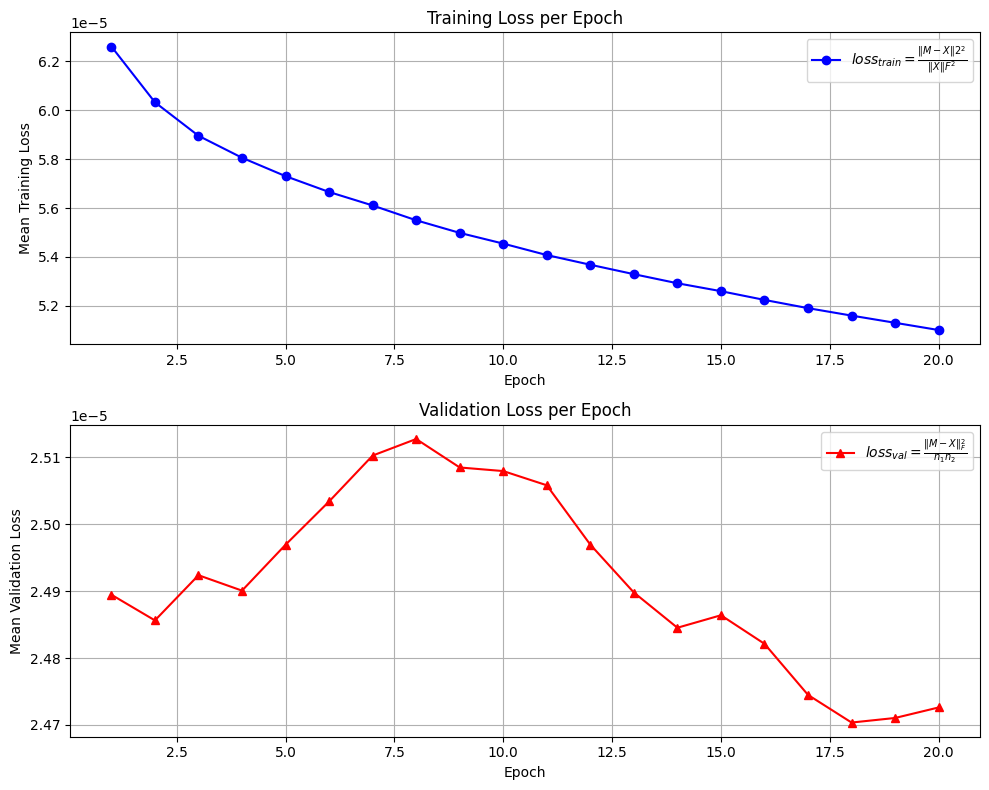

Project Name: Try 1 HuberMC-Net Q 30.0% DB 9.0

Configuring Network...
Instantiating Model...
Model Instantiated...

Parameters = 
{'size1': 150, 'size2': 300, 'rank': 10, 'device': 'cpu', 'hubreg_iters': 2, 'layers': 3, 'kernel': (3, 3), 'CalInGPU': False}

Epoch: 1, 2024-05-22 18:26:43, 

Epoch [1/20], Mean Training Loss:2.26477e-05, Mean Validation Loss:9.04324e-06
Epoch: 2, 2024-05-22 18:29:56, 

Epoch [2/20], Mean Training Loss:2.15472e-05, Mean Validation Loss:9.07441e-06
Epoch: 3, 2024-05-22 18:33:14, 

Epoch [3/20], Mean Training Loss:2.09796e-05, Mean Validation Loss:9.12905e-06
Epoch: 4, 2024-05-22 18:36:49, 

Epoch [4/20], Mean Training Loss:2.05962e-05, Mean Validation Loss:9.15727e-06
Epoch: 5, 2024-05-22 18:40:12, 

Epoch [5/20], Mean Training Loss:2.02773e-05, Mean Validation Loss:9.15988e-06
Saving Whole Model at Epochs: [5/20]
Saving Model Dict at Epochs: [5/20]
Epoch: 6, 2024-05-22 18:43:36, 

Epoch [6/20], Mean Training Loss:1.99885e-05, Mean Validation Loss:9.15429e

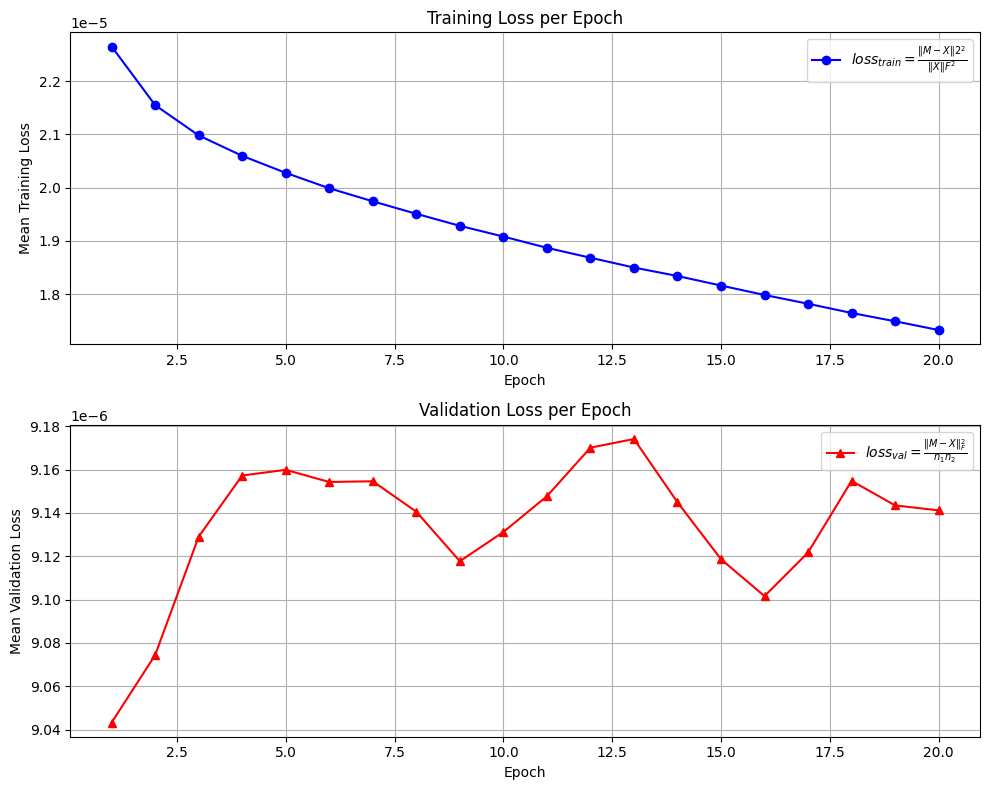

Project Name: Try 1 HuberMC-Net Q 40.0% DB 9.0

Configuring Network...
Instantiating Model...
Model Instantiated...

Parameters = 
{'size1': 150, 'size2': 300, 'rank': 10, 'device': 'cpu', 'hubreg_iters': 2, 'layers': 3, 'kernel': (3, 3), 'CalInGPU': False}

Epoch: 1, 2024-05-22 19:24:34, 

Epoch [1/20], Mean Training Loss:7.98193e-06, Mean Validation Loss:3.21688e-06
Epoch: 2, 2024-05-22 19:27:25, 

Epoch [2/20], Mean Training Loss:7.26586e-06, Mean Validation Loss:3.27738e-06
Epoch: 3, 2024-05-22 19:29:57, 

Epoch [3/20], Mean Training Loss:6.91471e-06, Mean Validation Loss:3.32248e-06
Epoch: 4, 2024-05-22 19:32:34, 

Epoch [4/20], Mean Training Loss:6.70804e-06, Mean Validation Loss:3.33361e-06
Epoch: 5, 2024-05-22 19:35:09, 

Epoch [5/20], Mean Training Loss:6.52167e-06, Mean Validation Loss:3.33615e-06
Saving Whole Model at Epochs: [5/20]
Saving Model Dict at Epochs: [5/20]
Epoch: 6, 2024-05-22 19:37:41, 

Epoch [6/20], Mean Training Loss:6.34738e-06, Mean Validation Loss:3.31417e

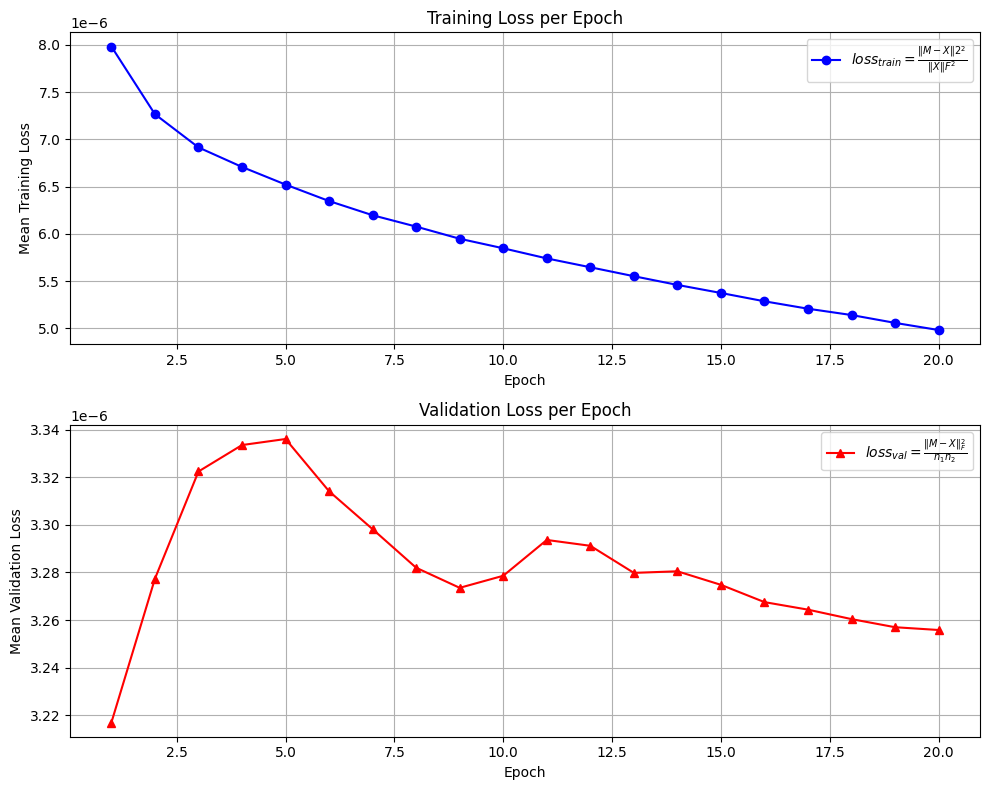

Project Name: Try 1 HuberMC-Net Q 50.0% DB 9.0

Configuring Network...
Instantiating Model...
Model Instantiated...

Parameters = 
{'size1': 150, 'size2': 300, 'rank': 10, 'device': 'cpu', 'hubreg_iters': 2, 'layers': 3, 'kernel': (3, 3), 'CalInGPU': False}

Epoch: 1, 2024-05-22 20:59:40, 

Epoch [1/20], Mean Training Loss:3.35060e-06, Mean Validation Loss:1.12746e-06
Epoch: 2, 2024-05-22 21:02:52, 

Epoch [2/20], Mean Training Loss:2.77202e-06, Mean Validation Loss:1.21154e-06
Epoch: 3, 2024-05-22 21:05:30, 

Epoch [3/20], Mean Training Loss:2.60120e-06, Mean Validation Loss:1.25287e-06
Epoch: 4, 2024-05-22 21:08:06, 

Epoch [4/20], Mean Training Loss:2.47231e-06, Mean Validation Loss:1.25139e-06
Epoch: 5, 2024-05-22 21:10:42, 

Epoch [5/20], Mean Training Loss:2.33926e-06, Mean Validation Loss:1.23163e-06
Saving Whole Model at Epochs: [5/20]
Saving Model Dict at Epochs: [5/20]
Epoch: 6, 2024-05-22 21:13:15, 

Epoch [6/20], Mean Training Loss:2.23035e-06, Mean Validation Loss:1.19788e

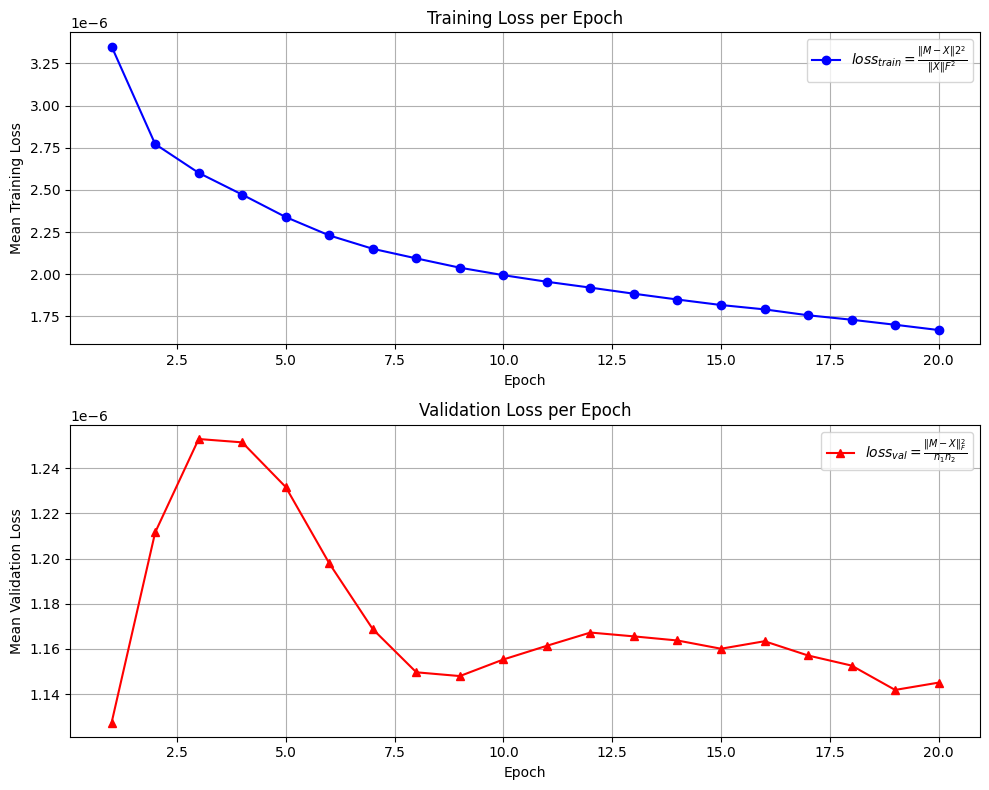

Project Name: Try 1 HuberMC-Net Q 60.0% DB 9.0

Configuring Network...
Instantiating Model...
Model Instantiated...

Parameters = 
{'size1': 150, 'size2': 300, 'rank': 10, 'device': 'cpu', 'hubreg_iters': 2, 'layers': 3, 'kernel': (3, 3), 'CalInGPU': False}

Epoch: 1, 2024-05-22 21:49:05, 

Epoch [1/20], Mean Training Loss:1.49022e-06, Mean Validation Loss:6.41056e-07
Epoch: 2, 2024-05-22 21:51:47, 

Epoch [2/20], Mean Training Loss:9.98828e-07, Mean Validation Loss:6.82718e-07
Epoch: 3, 2024-05-22 21:54:08, 

Epoch [3/20], Mean Training Loss:9.84482e-07, Mean Validation Loss:7.10241e-07
Epoch: 4, 2024-05-22 21:56:28, 

Epoch [4/20], Mean Training Loss:9.46549e-07, Mean Validation Loss:6.55587e-07
Epoch: 5, 2024-05-22 21:58:40, 

Epoch [5/20], Mean Training Loss:8.92279e-07, Mean Validation Loss:5.86886e-07
Saving Whole Model at Epochs: [5/20]
Saving Model Dict at Epochs: [5/20]
Epoch: 6, 2024-05-22 22:00:55, 

Epoch [6/20], Mean Training Loss:8.47279e-07, Mean Validation Loss:5.44425e

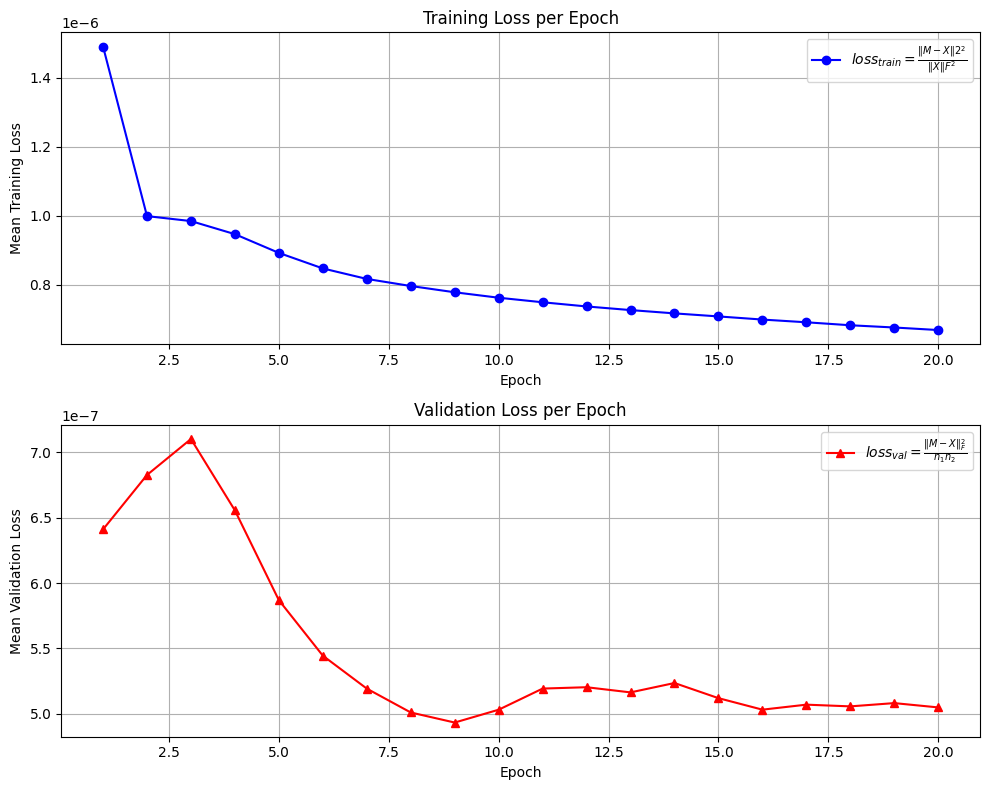

Project Name: Try 1 HuberMC-Net Q 70.0% DB 9.0

Configuring Network...
Instantiating Model...
Model Instantiated...

Parameters = 
{'size1': 150, 'size2': 300, 'rank': 10, 'device': 'cpu', 'hubreg_iters': 2, 'layers': 3, 'kernel': (3, 3), 'CalInGPU': False}

Epoch: 1, 2024-05-22 22:36:43, 

Epoch [1/20], Mean Training Loss:8.60116e-07, Mean Validation Loss:3.53905e-07
Epoch: 2, 2024-05-22 22:39:45, 

Epoch [2/20], Mean Training Loss:6.16482e-07, Mean Validation Loss:3.17079e-07
Epoch: 3, 2024-05-22 22:42:26, 

Epoch [3/20], Mean Training Loss:6.10839e-07, Mean Validation Loss:3.18336e-07
Epoch: 4, 2024-05-22 22:45:10, 

Epoch [4/20], Mean Training Loss:5.99742e-07, Mean Validation Loss:3.10300e-07
Epoch: 5, 2024-05-22 22:47:58, 

Epoch [5/20], Mean Training Loss:5.63410e-07, Mean Validation Loss:2.96053e-07
Saving Whole Model at Epochs: [5/20]
Saving Model Dict at Epochs: [5/20]
Epoch: 6, 2024-05-22 22:50:33, 

Epoch [6/20], Mean Training Loss:5.22342e-07, Mean Validation Loss:2.76663e

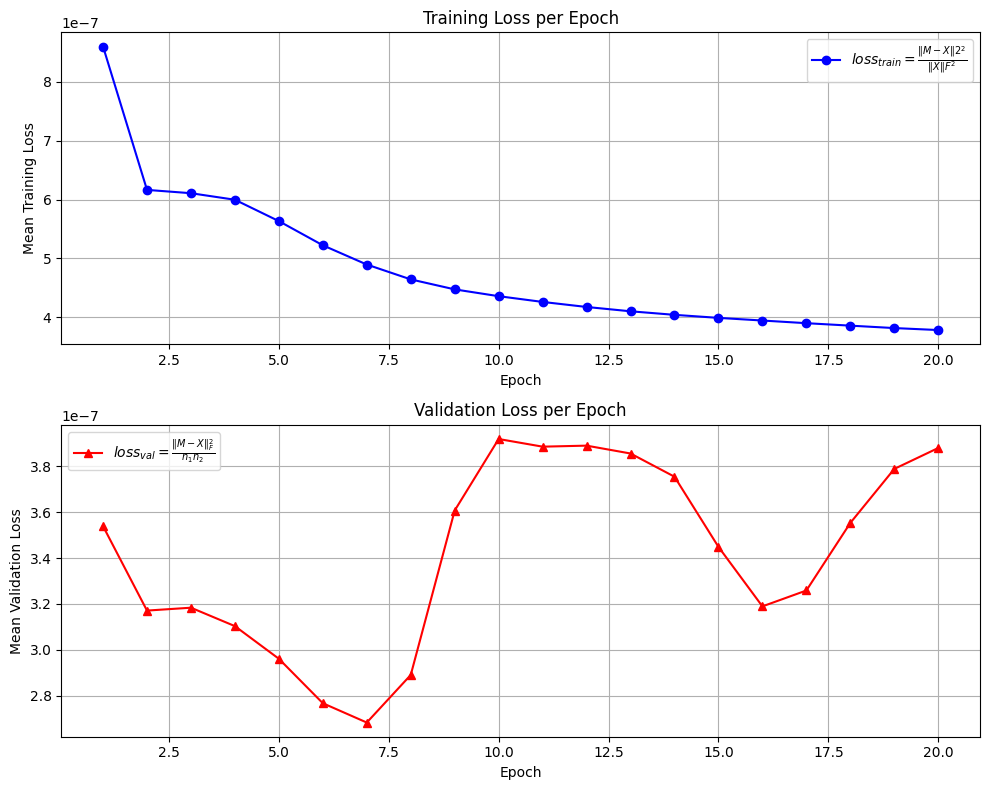

Project Name: Try 1 HuberMC-Net Q 80.0% DB 9.0

Configuring Network...
Instantiating Model...
Model Instantiated...

Parameters = 
{'size1': 150, 'size2': 300, 'rank': 10, 'device': 'cpu', 'hubreg_iters': 2, 'layers': 3, 'kernel': (3, 3), 'CalInGPU': False}

Epoch: 1, 2024-05-22 23:30:41, 

Epoch [1/20], Mean Training Loss:4.14135e-07, Mean Validation Loss:3.48849e-07
Epoch: 2, 2024-05-22 23:33:33, 

Epoch [2/20], Mean Training Loss:3.29696e-07, Mean Validation Loss:3.47209e-07
Epoch: 3, 2024-05-22 23:35:22, 

Epoch [3/20], Mean Training Loss:3.74094e-07, Mean Validation Loss:3.52734e-07
Epoch: 4, 2024-05-22 23:37:12, 

Epoch [4/20], Mean Training Loss:3.81126e-07, Mean Validation Loss:3.54557e-07
Epoch: 5, 2024-05-22 23:39:01, 

Epoch [5/20], Mean Training Loss:3.66089e-07, Mean Validation Loss:3.55120e-07
Saving Whole Model at Epochs: [5/20]
Saving Model Dict at Epochs: [5/20]
Epoch: 6, 2024-05-22 23:40:50, 

Epoch [6/20], Mean Training Loss:3.43340e-07, Mean Validation Loss:3.47107e

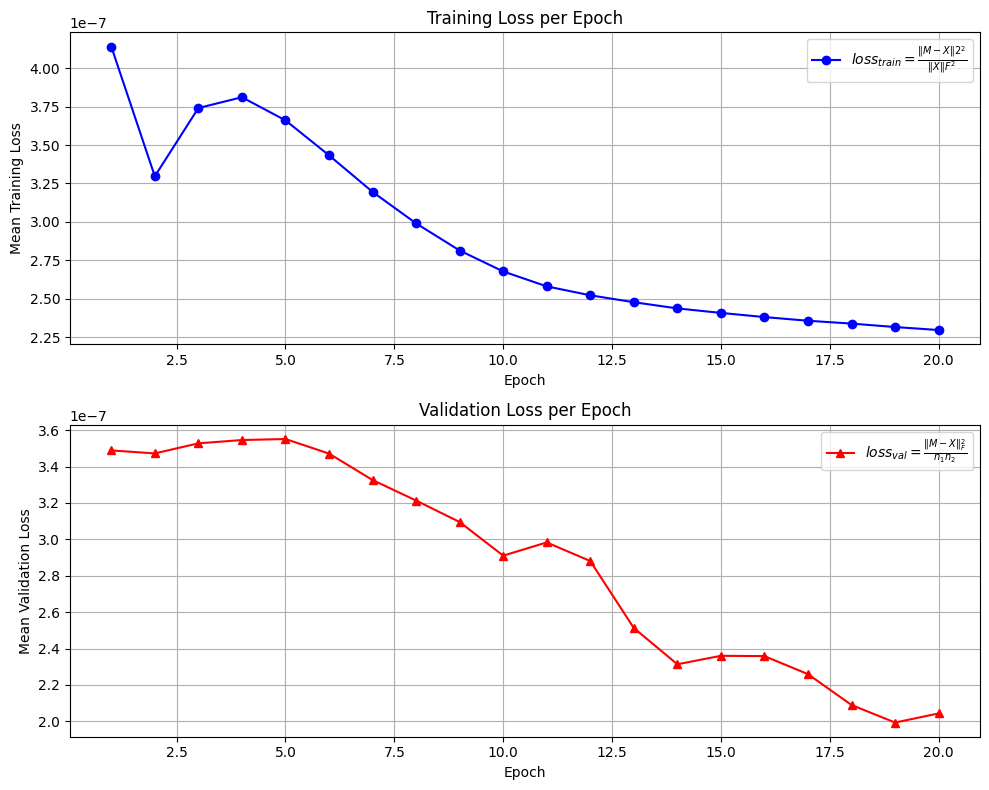

In [8]:
# Some settings for visualisation
matplotlib.use('Agg')
%matplotlib inline

seed = 123
torch.manual_seed(seed)

# Set parameters (including hyperparameters) and setting for saving/logging data
hyper_param_net = training.get_hyperparameter_grid('HuberMC-Net', TrainInstances = 20, ValInstances = 10, BatchSize = 5, ValBatchSize = 2, num_epochs = 20, learning_rate = 0.001)
params_net = get_default_param(gpu = False, model = 'HuberMC-Net')
CalInGPU = params_net['CalInGPU']

q_list = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
db_list = [9.0]

for q in q_list:
    for db in db_list:
        # ProjectName = TRY + ' ' + logs_and_results.get_current_time() + ' ' + hyper_param_net['Model'] + ' ' + 'Sampling Rate: ' + logs_and_results.get_q_str(q) + ' and DB ' + logs_and_results.get_noise_str(db)

        ProjectName = TRY + ' ' + hyper_param_net['Model'] + ' Q ' + logs_and_results.get_q_str(q) + ' DB ' + logs_and_results.get_noise_str(db)
        # Note: Removed time stamp from log file name as : not supported. Weird because this was not a problem in linux

        # Get log file
        logfile = logs_and_results.get_modularized_record(ProjectName, q, db, 'Logs', hyper_param_net, params_net, ROOT, SESSION)
        with open(logfile, 'w', 1) as log:
            print('Project Name: %s\n'%ProjectName)
            log.write('Project Name: %s\n\n'%ProjectName)

            # Get Model
            net = training.get_model(params_net, hyper_param_net, log)
            print('\nParameters = \n%s\n'%str(params_net))
            log.write('\nParameters = \n%s\n\n'%str(params_net))

            #Loading data and creating dataloader for both test and training
            # print('Loading Data phase...')
            log.write('Loading phase...\n')
            shape_dset = (params_net['size1'], params_net['size2'])
            
            train_loader, val_loader = dataset_processing.get_dataloaders(params_net = params_net, hyper_param_net = hyper_param_net, sampling_rate = q, db = db, ROOT = ROOT)

            # print('Finished loading.\n')
            log.write('Finished loading.\n\n')

            # Some additional settings for training including loss, optimizer,
            # floss = nn.functional.mse_loss(reduction = 'sum')
            floss = nn.MSELoss()
            optimizer = torch.optim.Adam(net.parameters(), lr = hyper_param_net['Lr'])
            # scheduler2 =  torch.optim.lr_scheduler.StepLR(optimizer, step_size= 1, gamma = 0.97, verbose = True)

            # Array for recording parameter values after each layer for each epoch etc
            outputs_L = revised_architecture.to_var(torch.zeros([shape_dset[0], shape_dset[1]]), CalInGPU) 
            lossmean_vec = np.zeros((hyper_param_net['Epochs'], ))
            lossmean_val_vec = np.zeros((hyper_param_net['Epochs'], ))


            # dummy variable to monitor and record progress for loss
            minloss = np.inf

            for epoch in range(hyper_param_net['Epochs']):
                print(f'Epoch: {epoch + 1}, {logs_and_results.get_current_time()}, \n')
                log.write(f'Epoch: {epoch + 1} ')
                log.write(logs_and_results.get_current_time() + '\n\n')

                # Train and Test Steps. (Record every 5 epochs)
                if (epoch + 1) % 5 == 0:
                    # print('Loading and calculating training batches...')
                    log.write('Loading and calculating training batches...\n')
                    startime = time.time()
                    loss_mean = training.train_step(net, train_loader, floss, optimizer, CalInGPU, hyper_param_net['TrainInstances'], hyper_param_net['BatchSize']) # remove alpha from train func
                    endtime = time.time()
                    # print('Training time is %f'%(endtime - startime))
                    log.write('Training time is %f'%(endtime - startime))

                    # print('Loading and calculating validation batches...')
                    log.write('Loading and calculating validation batches...\n')
                    startime = time.time()
                    loss_val_mean = training.test_step(net, val_loader, floss, CalInGPU, hyper_param_net['ValInstances'], hyper_param_net['ValBatchSize'])
                    endtime = time.time()
                    # print('Test time is %f'%(endtime - startime))
                    log.write('Test time is %f'%(endtime - startime))

                else:
                    loss_mean = training.train_step(net, train_loader, floss, optimizer, CalInGPU, hyper_param_net['TrainInstances'], hyper_param_net['BatchSize'])
                    loss_val_mean = training.test_step(net, val_loader, floss, CalInGPU, hyper_param_net['ValInstances'], hyper_param_net['ValBatchSize'])

                # Update Record and Parameters
                lossmean_vec[epoch] = loss_mean
                lossmean_val_vec[epoch] = loss_val_mean


                print('Epoch [%d/%d], Mean Training Loss:%.5e, Mean Validation Loss:%.5e'
                      %(epoch + 1, hyper_param_net['Epochs'], loss_mean, loss_val_mean))

                # Update Log after every 5 epochs. Make a plot of MSE against epochs every 5 epochs. Save Model in whole/dict form every five epochs.
                if (epoch + 1) % 5 == 0:
                    print(f"Saving Whole Model at Epochs: [{epoch + 1}/{hyper_param_net['Epochs']}]")
                    model_whole_path = logs_and_results.get_modularized_record(ProjectName, q, db, 'Saved Models - Whole', hyper_param_net, params_net, ROOT, SESSION, current_epoch = epoch + 1)
                    # torch.save(net, model_whole_path)
                    print(f"Saving Model Dict at Epochs: [{epoch + 1}/{hyper_param_net['Epochs']}]")
                    model_state_dict_path = logs_and_results.get_modularized_record(ProjectName, q, db, 'Saved Models - Dict', hyper_param_net, params_net, ROOT, SESSION, current_epoch = epoch + 1)
                    # torch.save(net.state_dict(), model_state_dict_path)

                    # print('Epoch [%d/%d], Mean Training Loss:%.5e, Mean Validation Loss:%.5e'
                    # %(epoch + 1, hyper_param_net['Epochs'], loss_mean, loss_val_mean))
                    # print('loss_lowrank_mean', loss_lowrank_mean)
                    # print('loss_val_lowrank_mean', loss_val_lowrank_mean)
                    # print(f'c: {c_list}, lamda: {lamda_list}, mu: {mu_list}')

                    # log.write('loss_lowrank_mean %.5e\n' %(loss_lowrank_mean))
                    # log.write('loss_val_lowrank_mean %.5e\n' %(loss_val_lowrank_mean))
                    log.write('Epoch [%d/%d], Mean Training Loss:%.5e, Mean Validation Loss:%.5e\n'
                              %(epoch + 1, hyper_param_net['Epochs'], loss_mean, loss_val_mean))
                    np.set_printoptions(precision = 3)

                    if True or loss_val_mean < minloss:
                        # print('saved at [epoch%d/%d]'%(epoch + 1, hyper_param_net['Epochs']))
                        log.write('saved at [epoch%d/%d]\n' %(epoch + 1, hyper_param_net['Epochs']))
                        minloss = min(loss_val_mean, minloss)

            # Finish off by observing the minimum loss on validation set

            #Print min loss
            # print('\nMin Loss = %.4e'%np.min(lossmean_val_vec))
            log.write('\nMin Loss = %.4e'%np.min(lossmean_val_vec))

            # Plotting MSE vs Epoch and Saving it

            # Get Directory where we have to save the plot
            dir = logs_and_results.get_modularized_record(ProjectName, q, db, 'Plots', hyper_param_net, params_net, ROOT, SESSION, current_epoch = epoch + 1)
            logs_and_results.plot_and_save_mse_vs_epoch(lossmean_vec, lossmean_val_vec, dir)

In [24]:
# Compiling all results in a single pdf

root_directory = r'C:/Users/Talha/OneDrive - Higher Education Commission/Documents/GitHub/ConvHuberMC/HuberMC_Data'
output_pdf = r'compiled_output.pdf'  # path for the output PDF

png_files = img_pdf_compiler.collect_png_files(root_directory)
img_pdf_compiler.pngs_to_pdf(png_files, output_pdf)